Домашнее задание 10 (после Лекции №11)
Задание №2: 

2. Взять любую видеопоследовательность (желательно вид сверху) - например полет дрона. Можете скачать из  интернета или взять что то с работы. 
Зафиксировав точку (например центр экрана) выполнить стабилизацию данной точки с использованием матрицы афинного преобразования 
(считая матрицу между кадрами вы всегда сможете понять где именно находится точка на изображении, а по отклонению самой точки вы можете определить точность самого алгоритма).
Не берите 4к - долго считать, HD будет достаточно
Посчитать расстояние между точками и ошибку в пикселях.
Попробуйте добавить шум к изображению, посмотрите как меняется точность (положение точки). 
Добавьте фильтр к изображению для улучшения контрастности (любой который найдете).
Оцените как влияет выбор метода определения матрицы афинного преобразования - например estimateAffine2D и его аналоги (аналоги найдите самии).
Оцените как влияет выбор детектора/дескриптора особых точек на результат. Какой метод даст лучший и самый быстрый результат? 

Анализ задания: используем функции библиотеки OpenCV, в частности, оптический поток. 
Из выполненного первого задания возьмем функцию расчета матрицы гомоморфизма (аффинного преобразования, связывающего две картинки).
Предварительно готовим исходные данные, а именно, загружаем ролик из интернета, вырезаем нужный нам кусок, сохраняем как video.mp4.
Грузим полученный ролик с помощью cv2.
Выводим первый кадр и находим точку, за которой будем следить. Сохраняем ее координаты в вектор X0 = [x0, y0, 1].
Выводим последний кадр и находим, где находится первая точка. Сохраняем ее координаты на этом кадре в вектор XN = [xn, yn, 1].
Затем последовательно считываем текущий и следующий кадр из ролика, находим матрицу А аффинного преобразования. Умножая матрицу А на вектор Х координаты отслеживаемой точки на текущем кадре, находим следующий вектор Х - расчетные координаты точки на следующем кадре.
Таким образом, дойдя до последнего кадра, найдем вектор ХС - расчетные координаты точки на последнем кадре.
Затем находим расстояние между точками ХN и XC, которое покажет ошибку вычисления положения точки с помощью аффинных преобразований.
Затем то же самое проделываем с добавлением шума на видео, и наоборот, с фильтрацией.

Загрузка библиотек и файла видео.

In [106]:
quit # reset all variables for repeated run of the program

# loading necessary libraries and two pictures
import cv2
import numpy as np
import matplotlib.pyplot as plt

video_path = 'video.mp4'  # file name (and path if necessary)

Выводим первый и последний кадр. Визуализируем одну и ту же точку на обоих. Вручную подбираем координаты точек.

Функция извлечения первого и последнего кадра. Из-за особенностей современных кодеков прямой доступ сразу к нужному кадру невозможен - нужно прокручивать видео с начала до конца, по ходу дела выбирать кадры и сохранять нужные.

In [107]:
def extractFrames(filename):
   """Opens video file and find 1st and last frame"""
   myvid = cv2.VideoCapture(filename) # loading into cv2
   # Check if video opened successfully
   if not myvid.isOpened():
        print("Video file not found")
   else:
        print("Video is opened") 
   fps = myvid.get(cv2.CAP_PROP_FPS)  
   # looking fo the 1st and last frame of the video:
   ret, frame = myvid.read()
   frame_first = frame # first frame
   cv2.imwrite('frame_1.jpg', frame_first)
   i = 0
   while True:
        i += 1
        frame_previous = frame
        ret, frame = myvid.read()
        if i == 1:
            cv2.imwrite('frame_2.jpg', frame)
        if not ret:
            frame_last = frame_previous # last frame
            myvid.release()    # releasing video channel after viewing is over
            cv2.destroyAllWindows()   # close all windows
            return frame_first, frame_last, fps

Выводим первый и последний кадр видео.
Подбираем координаты x0,y0 одного и того же объекта на первом кадре и его же координаты xn, yn на последнем кадре
Ставим точку на изображении и еще обводим ее кружочком, с помощью этой точки и кружочка, собственно, и подбираем вручную координаты.

Video is opened


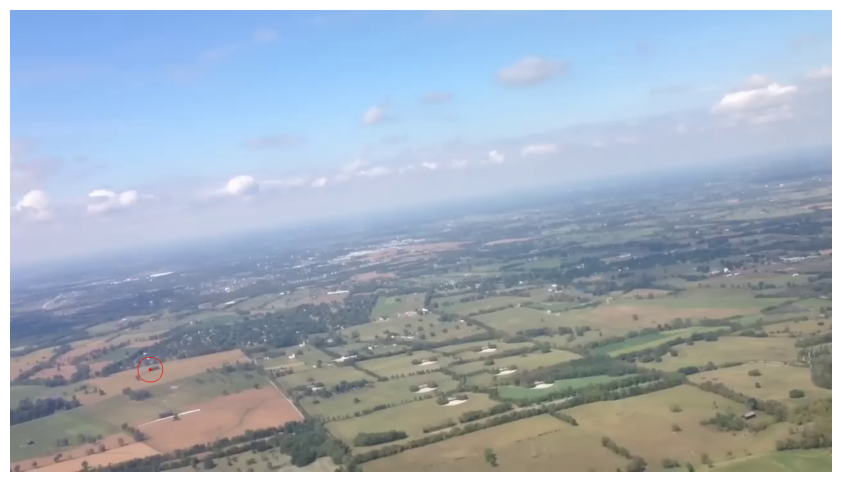

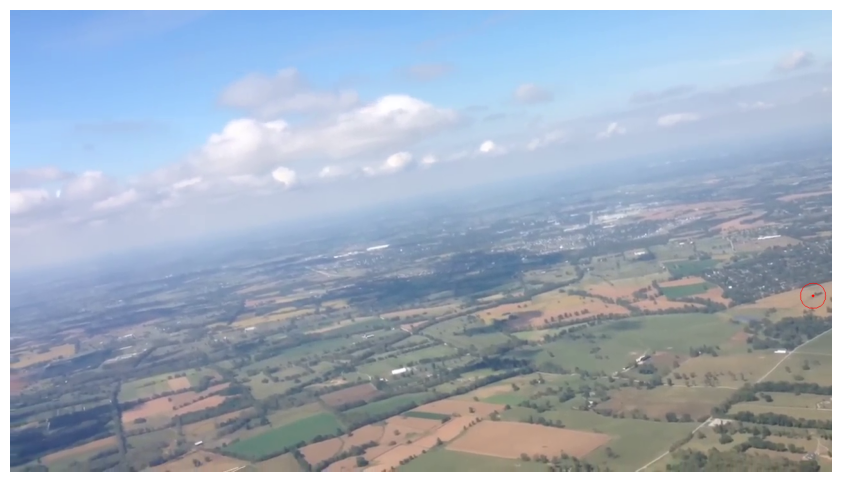

In [108]:
# manually selected coordinates of an object
# The object is a left side of a remote object in the field - maybe a long agricultural building 
x0 = 218
y0 = 560
xn = 1250
yn = 445
pic1, pic2, fps = extractFrames(video_path)
y_max, x_max, _ = pic1.shape # frame size

# convert color image into RGB image 
frame_first = cv2.cvtColor(pic1, cv2.COLOR_BGR2RGB)
frame_first_point = cv2.circle(frame_first, [x0, y0], 2, (255, 0, 0), -1)  # point
frame_first_point = cv2.circle(frame_first, [x0, y0], 20, (255, 0, 0), 1)  # circle
# show image 1
plt.figure(figsize=(16, 6), dpi=100)
plt.imshow(frame_first_point)
plt.axis('off')
plt.show()

frame_last = cv2.cvtColor(pic2, cv2.COLOR_BGR2RGB) 
# show image 2 
frame_last_point = cv2.circle(frame_last, [xn, yn], 2, (255, 0, 0), -1)  # point
frame_last_point = cv2.circle(frame_last, [xn, yn], 20, (255, 0, 0), 1)  # circle
plt.figure(figsize=(16, 6), dpi = 100)
plt.imshow(frame_last_point)
plt.axis('off')
plt.show()

Функция нахождения массивов соответственных точек на двух картинках (кадрах). Здесь нами добавлена возможность применения маски для исключения медленно меняющейся небесной части изображения и отслеживания только быстрее движущегося ландшафта.

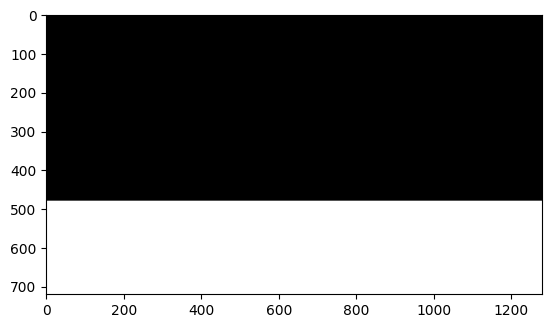

In [109]:
mask0 = np.zeros((y_max, x_max), dtype = 'uint8') # creating mask with zeros, size like pic1 has
# putting ones into lower part of the image (i.e. where x > x_max/2, since the origin is in upper corner):
border = int(mask0.shape[0] / 1.5) # border of used and unused areas
mask0[border:, :] = 255 
# mask0 = 255 * np.ones((y_max, x_max), dtype = 'uint8') # to remove mask make all points = 255
# show mask
plt.imshow(mask0, cmap = 'gray', vmin=0, vmax=255)
plt.show()

def get_transform_keypoints(img0, img1, mask = mask0):
    # Function takes two images and returns two sets of keypoint, one per the image
    # mask is an image of the same size having zeros in the area to be unused
    gray0 = cv2.cvtColor(img0, cv2.COLOR_RGB2GRAY)
    gray1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    
    # in our picture we have sky in upper part and a lanscape in the lower part
    # so we need to create and apply mask to remove sky from our consideration
    # it will be a picture with zeros in upper half and ones in lower half:
    corners0 = cv2.goodFeaturesToTrack(gray0, 500, 0.01, 30, mask = mask) # finds keypoints very quickly, epsilon=0.01, min_dist = 40
      
    corners1, status, err = cv2.calcOpticalFlowPyrLK(gray0, gray1, corners0, None)
    # Selecting good key points
    good_new = corners1[status == 1]
    good_old = corners0[status == 1]
    # Преобразуем точки в объекты KeyPoint
    kp1 = [cv2.KeyPoint(x=float(p[0]), y=float(p[1]), size=1) for p in good_old]
    kp2 = [cv2.KeyPoint(x=float(p[0]), y=float(p[1]), size=1) for p in good_new]
    
    # Создаем объекты DMatch
    # matches = [cv2.DMatch(_imgIdx=0, _queryIdx = i, _trainIdx = i, _distance = 0) for i in range(len(kp1))]
    # Визуализируем совпадения
    # match_img = cv2.drawMatches(img0, kp1, img1, kp2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)    
    # return match_img, kp1, kp2
    return kp1, kp2

Функция нахождения аффинного преобразования для двух картинок (кадров видео)
В качестве исходных данных выступают два массива соответствующих точек

In [110]:
def estimate_affine_matrix(cur_matched_kp, prev_matched_kp, method):
    """    
    :param matched_keypoints: output of match_keypoints util function; tuple of (cur_matched_kp, prev_matched_kp)
    :return: 2D affine transform matrix 3 x 3
    """
    M = cv2.estimateAffine2D(np.array(prev_matched_kp), np.array(cur_matched_kp),method = method)[0]  #cv2.LMEDS may be
    # other method, much worse:
    # M = cv2.estimateAffinePartial2D(np.array(prev_matched_kp), np.array(cur_matched_kp),method = method)[0]  #cv2.LMEDS may be
    """
    # print(transform)    
    if transform is not None:
        # translation x
        dx = transform[0, 2]
        # translation y
        dy = transform[1, 2]
        # rotation
        da = np.arctan2(transform[1, 0], transform[0, 0])
    else:
        dx = dy = da = 0

    # return [dx, dy, da], transform
    m = [dx, dy, da]
    """
    ATM = np.append(M, np.array([0,0,1])).reshape(3,3) # adding 3rd string [0; 0; 1]
    return(ATM) # return affine transform matrix

Прокручиваем ролик снова, находим матрицу гомоморфизма (= матрицу аффинного преобразования) для каждой пары кадров.
С помощью этой матрицы рассчитываем теоретическое положение исходной точки на следующем кадре. Рисуем точку в ходе демонстрации видео.

In [ ]:
myvid = cv2.VideoCapture(video_path) # loading into cv2
# Check if video opened successfully
if not myvid.isOpened():
     print("Video file not found")
else:
     print("Video is opened") 
ret, frame = myvid.read() # reading 1st frame
# videofile for saving result:
result_video = cv2.VideoWriter('result_video.mp4',  
                         cv2.VideoWriter_fourcc(*'divx'), 
                         fps, (x_max, y_max))
X = np.array([[x0, y0, 1]]) # coordinates of the object point on the 1st frame
X.shape = (3,1) # force X to be a column vector
# initial coordinates:
x = x0
y = y0
# transform to coordinates with lower left origin (instead of cv2 upper left origin, to fit with )
print(f'initial X is equal to:\n{X[0]}\n{X[1]}\n{X[2]}')
i = 0
while  True: # i < 1:
     i +=1     
     # print(f'Current frame: {i}')
     frame_previous = frame
     ret, frame = myvid.read()
     if ret:
          # remembder previous coordinates
          x_previous = x
          y_previous = y
          # Optional - Gaussian blur
          # frame = cv2.GaussianBlur(frame, (5, 5), 0)
          # Optional: sharpness increasing by subtracting blurred image:
          # frame = frame - cv2.GaussianBlur(frame, (5, 5), 0)
          # Optional: sharpness increasing by applying 2D filtering:
          kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])
          frame = cv2.filter2D(src=frame, ddepth=-1, kernel=kernel)

          kp1, kp2 = get_transform_keypoints(frame, frame_previous) # get keypoints
          # formatting keypoint arrays:
          src_pts = np.float32([m.pt for m in kp1]).reshape(-1, 1, 2)
          dst_pts = np.float32([m.pt for m in kp2]).reshape(-1, 1, 2)
          M = estimate_affine_matrix(src_pts, dst_pts, cv2.LMEDS)
          # print('Affine matrix:')
          # print(M)
          # X = M @ X # coordinates of the object point in the current frame   
          x = M[0,0] * x_previous + M[0,1] * y_previous + M[0,2]
          y = M[1,0] * x_previous + M[1,1] * y_previous + M[1,2]
          # print('Point coordinates')        
          # print((x,y))
          # show video 
          if x >-1 and x < x_max and y >-1 and y < y_max:
               frame_to_show = cv2.circle(frame, [int(x), int(y)], 2, (255, 0, 0), -1)  # adding point
               frame_to_show = cv2.circle(frame_to_show, [int(x), int(y)], 20, (255, 0, 0), 1) # adding circle
          else:
               frame_to_show = frame
          cv2.imshow('frame', frame_to_show)
          # save video with the mark tracing the object
          result_video.write(frame) 
          p = cv2.waitKey(10) & 0xFF
          if p == ord('q'): # pressing "q" (quit) closes the windows
               myvid.release()    # releasing video channel after viewing is over
               cv2.destroyAllWindows()   # close all windows
               result_video.release() 
               break
     else:
          myvid.release()    # releasing video channel after viewing is over
          cv2.destroyAllWindows()   # close all windows
          result_video.release()           
          break
x_found = x
y_found = y     


Video is opened
initial X is equal to:
[218]
[560]
[1]


Рассчитываем расстояние между действительным и расчетным положением предмета:

In [ ]:
distance = np.sqrt((x_found - xn)**2 + (y_found - yn)**2)
print(f'Distance between the real object position and its calculated position, points: {distance:.1f}')


Distance between the real object position and its calculated position, points: 535.4


Выводы:
В ходе работы на основе ролика длительностью 26 с, снятого из самолета, проведено нахождение расчетного положения объекта в кадре с помощью матрицы гомоморфизма, расчитываемой на каждом шаге для пары кадров - текущего и предыдущего. 
С помощью матрицы гомоморфизма (матрицы аффинного преобразования) рассчитывалось положение точки объекта, которое оно должно иметь на основании смещения, даваемого рассчитанной матрицей.
Между реальным и расчетным положением точки имеется расхождение, зависящее от настроек различных параметров расчета. 
Для поиска ключевых точек на каждой из двух картинок и их сопоставления между собой использовался метод оптического потока: cv2.calcOpticalFlowPyrLK. 
Для расчета аффинного преобразования по найденному множеству пар точек использовалась функция cv2.estimateAffine2D с методом cv2.LMEDS. 
В ходе расчетов мы покадрово визуализировали положение расчетной точки, так что, просматривая ролик, можно было наблюдать постепенное расхождение расчетного и истинного положения точки.
При использовании всей площади кадра расчетное расстояние между реальным и расчетным положением предмета составило 11.7 пикселей (для estimateAffine2D, для estimateAffinePartial2D). 
Наблюдая за движением точки в видеоролике, мы пришли к предположению, что на точность отслеживания может влиять движение неба - поскольку угловая скорость облаков отличается от угловой скорости предметов на земле, то учет движения облаков снижает точность расчета матрицы гомоморфизма. Поэтому пришлось ввести маску, закрывающую верхнуюю часть кадра.   
Тогда, при использовании той же функции, но при маскировании верхних двух третей кадра (чтобы убрать небо из расчетов) расстояние между реальным и расчетным положением предмета составило приятные 3.6 пикселя. 
Если, для эксперимента, сглаживать шумы на каждом кадре, для чего размывать изображение каждого кадра с помощью гауссова фильтра cv2.GaussianBlur, сохраняя маску, точность отслеживания предмета составит  5.8 пикселя (то есть ухудшится по сравнению с неразмытым изображением примерно в 5.8/3.6 = 1.6 раза).
С другой стороны, мы попытались увеличить четкость изображения (с помощью того же размытия и вычитания размытого кадра из исходного) и посмотреть, как это повлияет на результат. Получилась точность отслеживания объекта 233 пикселя, то есть этот эксперимент блистательно провалился. По факту это было даже не увеличение четкости, а нахождение краёв предметов на изображении.
Далее мы использовали увеличение четкости с помощью двумерной фильтрации и найденной в интернете матрицы ядра:
          kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])
 Этот вариант оказался отлично работающим - разность между расчетным положением объекта и реальным положением составила 1.1 пикселя.
Метод estimateAffinePartial2D показал себя хуже - вместо 1.1 пикселя расхождение составило целых 535 пикселей.

